In [1]:
source('helpers.R')

In [ ]:
library(survival)
library(survminer)

In [3]:
nks <- readRDS("../../../ProcessedData/seurat/nks_final.rds")

In [4]:
pfs_tbl <- read.csv("../../../RawData/clinical_data/PFSforDana_latest.csv")
rownames(pfs_tbl) <- pfs_tbl$patient
pfs_tbl$Patient <- pfs_tbl$patient

In [7]:
props <- nks@meta.data %>% 
  filter(Day %in% c("D0","D7")) %>% 
  group_by(Patient, Day) %>%
  summarise(prop = mean(cell_type == "CD56dim_CD16pos_NK"), .groups = "drop") %>%
  tidyr::pivot_wider(names_from  = Day, values_from = prop, names_prefix = "prop_") %>%
  mutate(delta_prop = 100*(prop_D7 - prop_D0))
props$responder_status_short <- ifelse(props$Patient %in% c('P2', 'P3', 'P4', 'P7'), "R", "NR")

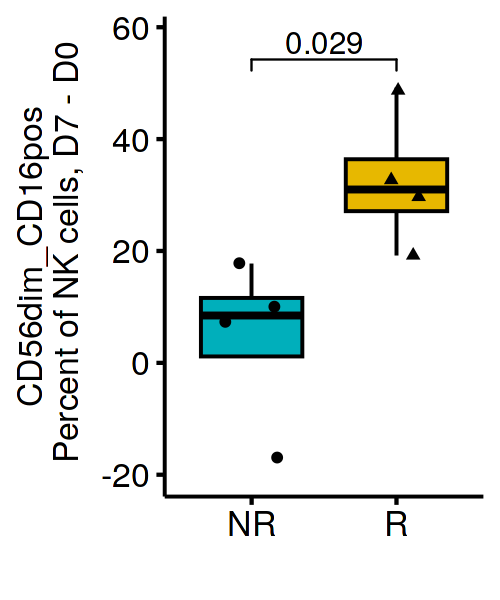

In [9]:
options(repr.plot.width = 2.5, repr.plot.height = 3, repr.plot.res=200)
p <- ggboxplot(props, "responder_status_short", "delta_prop",
    fill = "responder_status_short", palette = c("#00AFBB", "#E7B800"),
    add = "jitter", shape = "responder_status_short") +
    stat_compare_means(comparisons = list(c(1,2)), label.y = c(51)) + ylim(-20,58) +
    xlab('') +  ylab('CD56dim_CD16pos\n Percent of NK cells, D7 - D0') + NoLegend()
p

In [10]:
pdf(file.path(panel.path, paste0("NK_changein_cd56_percent_ofNK.pdf")), width=2.5, height=3)
p
dev.off()

pdf 
  2

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


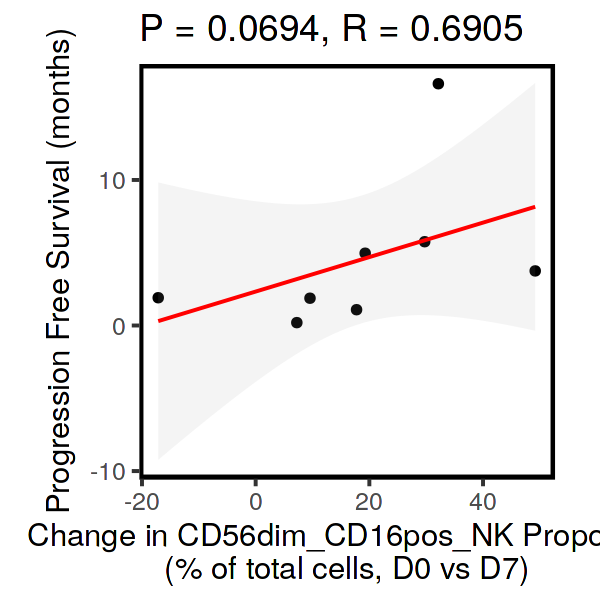

In [11]:
df <- props %>% inner_join(pfs_tbl, by = "Patient")

P <- c("P1","P3","P4","P6","P2","P5","P7","P8")
n <- subset(nks, Day %in% c("D0","D7"))
t <- table(n$cell_type, n$sample_id)
d <- 100*(t["CD56dim_CD16pos_NK", paste0(P,"D7")]/colSums(t)[paste0(P,"D7")] -
          t["CD56dim_CD16pos_NK", paste0(P,"D0")]/colSums(t)[paste0(P,"D0")])
y <- pfs_tbl[P,"pfs"]; ct <- cor.test(d, y, method="spearman")

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=200)
p <- ggplot(data.frame(d, y), aes(d, y)) +
  geom_point(size = 1) +
  geom_smooth(method = "lm", colour = "red", linewidth = 0.5, alpha = 0.1, se = T) +
  labs(
    x     = "Change in CD56dim_CD16pos_NK Proportion\n(% of total cells, D0 vs D7)",
    y     = "Progression Free Survival (months)",
    title = sprintf("P = %.4f, R = %.4f", ct$p.value, ct$estimate)
  ) +
  theme_classic() +
  theme(
    panel.border   = element_rect(color = "black", fill = NA, size = 1),
    panel.grid     = element_blank(),
    axis.line      = element_blank(),
    plot.margin    = margin(5, 5, 5, 5),
    aspect.ratio   = 1
  )
p
ggsave(file.path(panel.path, paste0("NK_changein_cd56_percent_ofNK_spearman.pdf")), p, width = 3, height = 3, device = cairo_pdf, family = "sans", dpi = 300)

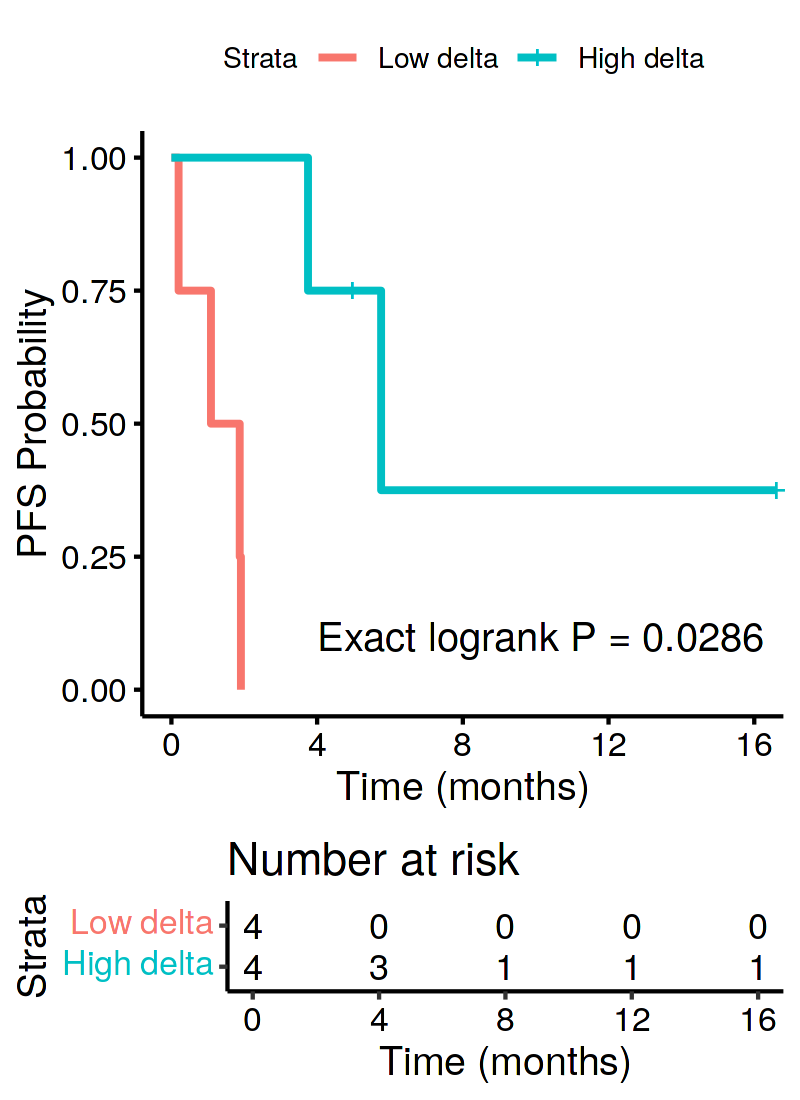

In [21]:
library(coin)
df$group <- factor(
  ifelse(df$delta_prop >= median(df$delta_prop, na.rm = TRUE), "High delta prop", "Low delta prop"),
  levels = c("Low delta prop","High delta prop")
)
logrank_ex <- logrank_test(Surv(pfs, PFS.event.yes.1) ~ group, data = df, distribution = "exact")
p_exact <- pvalue(logrank_ex)

fit_km <- survfit(Surv(pfs, PFS.event.yes.1) ~ group, data = df) 
options(repr.plot.width = 4, repr.plot.height = 5.5, repr.plot.res=200)
p <- ggsurvplot(fit_km, data = df, risk.table = TRUE, pval = paste0("Exact logrank P = ", signif(p_exact, 3)),
  pval.coord = c(4, 0.1), legend.labs = c("Low delta", "High delta"), xlab = "Time (months)", ylab = "PFS Probability"
)
p

In [17]:
pdf(file.path(panel.path, paste0("changein_cd56dim_cd16pos_KM_curves_stratified_by_median.pdf")), width=4, height=5.5)
p
dev.off()

pdf 
  2

In [25]:
summary(fit_km)$table

,records,n.max,n.start,events,rmean,se(rmean),median,0.95LCL,0.95UCL
group=Low delta prop,4,4,4,4,1.266447,0.3497725,1.480263,0.1973684,NA
group=High delta prop,4,4,4,2,9.324967,3.2973634,5.756579,3.7500000,NA


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
"Loglik converged before variable  1 ; coefficient may be infinite. "


         chisq df p
group  3.3e-10  1 1
GLOBAL 3.3e-10  1 1


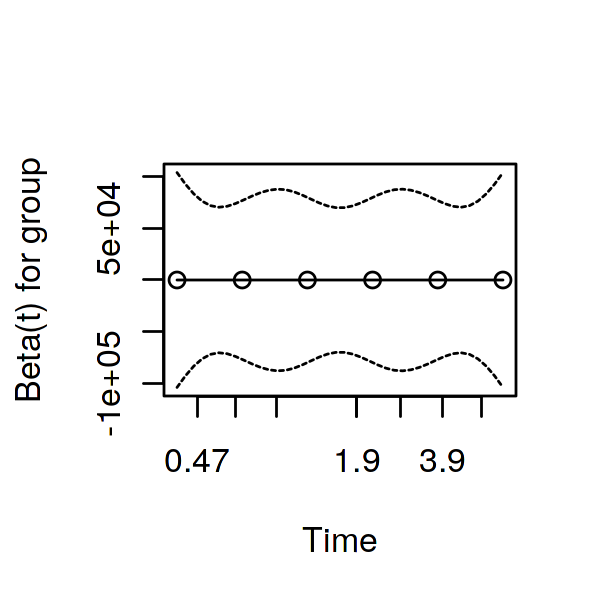

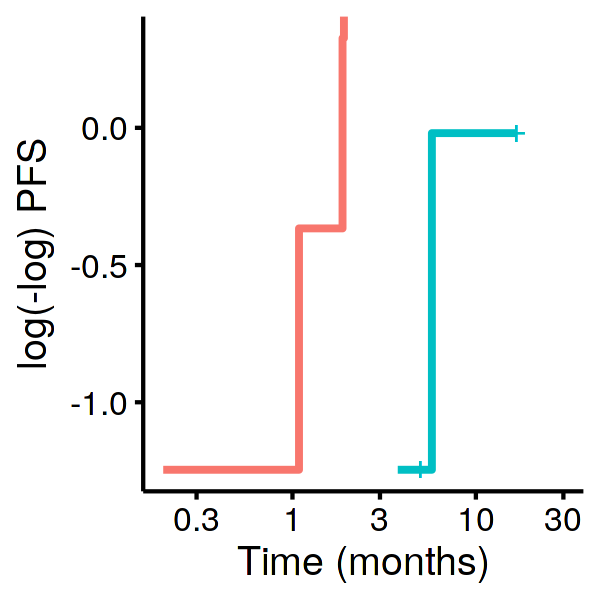

In [27]:
cox_temp <- coxph(Surv(pfs, PFS.event.yes.1) ~ group, data = df)
ph_test <- cox.zph(cox_temp)
print(ph_test)

options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=200)
plot(ph_test)
ggsurvplot(
  fit_km,
  data    = df,
  fun     = "cloglog",      
  legend  = "none",
  xlab    = "Time (months)",
  ylab    = "log(-log) PFS"
)
